The KD-tree is a data-structure that allows us to keep track of partioning in space.
This particular dealization helps us with breaking a (d-dimensional) cube into smaller equal cubes.

In [1]:
import numpy as np

import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

First, we need to make a cube class, which will act as the spatial part of the KD-tree.
This class has several members that may be useful, but we may just use some of them or add new ones as we progress.

In [29]:
class Cube:
    def __init__(self,center,distance):
        self.center=center
        self.distance=distance
        self.dim=len(center)

        self.generate_signs()#this list will hep us move a point towards backwards and forward directions in all axes 
        self.vertex_points()
        
    def generate_signs(self):
        '''
        The code below generates a list of signs that will move a point to all posible directions.
        Example for 2 dimensions this will give us
        
        [
            [1,1],
            [1,-1],
            [-1,1],
            [-1,-1]
        ]
        
        In three dimensions  
        [
            [1, 1, 1],
            [1, 1, -1],
            [1, -1, 1],
            [1, -1, -1],
            [-1, 1, 1],
            [-1, 1, -1],
            [-1, -1, 1],
            [-1, -1, -1]
        ]
        
        I came up with this code by trying different things and simplifying the result.
        
        What you need to do to replicate it is to draw on a board what you wat to do:
        take all possible combinations od size=self.dim of a list of +1 and -1 (there are dim**2 combinations).
        What you need to do is understand how to do this:
        
        + +
        + -
        - +
        - -
        
        Then this
        + + +
        + + -
        + - +
        + - -
        - + +
        - + -
        - - +
        - - -
        
        Then the pattern emerges: the last one changes every 1 step the second to last every 2, third to last every 4. 
        Translate this into a for-loop, and you have your result :)
        '''
        self.signs=[[0 for __ in range(self.dim)] for _ in range(2**self.dim)]
        for j in range(self.dim):
            count=0
            for i in range(2**self.dim):
                self.signs[i][j]=(-1)**count
                if (i+1)%(2**(self.dim-1-j))==0:
                    count+=1
                    if count==2:
                        count=0 

    def check_point(self,point):
        '''check whether point is inside this square'''
        for i in range(self.dim):
            if point[i]>self.center[i]+self.distance or point[i]<self.center[i]-self.distance:
                return False
        
        return True
    
    
    #ideally this would be static method...
    def check_cube(self,cube):
        '''Check if another cube intersects this one. This means that they share a volume.'''
        for vertex in self.vertices:
            if cube.check_point(vertex):
                return True
        for vertex in cube.vertices:
            if self.check_point(vertex):
                return True
        return False
    
    
    def vertex_points(self):
        '''generate all vertex points of the cube'''
        
        self.vertices=[]
        for bound in range(2**self.dim):
            self.vertices.append([self.center[d]+self.distance*self.signs[bound][d] for d in range(self.dim)])

            
    def random_point(self):
        '''generate a random point in this cube'''
        
        point=[]
        
        for d in range(self.dim):
            _M=self.center[d]+self.distance
            _m=self.center[d]-self.distance
            point.append(np.random.rand()*(_M-_m)+_m)
            
        return point

In [193]:
Cube([0.5]*4,1).signs

[[1, 1, 1, 1],
 [1, 1, 1, -1],
 [1, 1, -1, 1],
 [1, 1, -1, -1],
 [1, -1, 1, 1],
 [1, -1, 1, -1],
 [1, -1, -1, 1],
 [1, -1, -1, -1],
 [-1, 1, 1, 1],
 [-1, 1, 1, -1],
 [-1, 1, -1, 1],
 [-1, 1, -1, -1],
 [-1, -1, 1, 1],
 [-1, -1, 1, -1],
 [-1, -1, -1, 1],
 [-1, -1, -1, -1]]

In [288]:
def sign(d,i):
    if i%(2**d)<2**(d-1):
        return -1
    else:
        return 1

In [294]:
dim=3
for i in range(1,2**dim+1):
    print([sign(d,i) for d in range(1,dim+1)])

[1, -1, -1]
[-1, 1, -1]
[1, 1, -1]
[-1, -1, 1]
[1, -1, 1]
[-1, 1, 1]
[1, 1, 1]
[-1, -1, -1]


The actual tree class helps us construct and transverse the tree. There are several methods that may not be useful. Also, we add some methods and variables that are useful when the tree is made in order to hold points. 

I use this to find the nearest neighbour of a given point. The way I will do it is the following:
1. Find one point in each node. I do this because otherwise I would need to transverse the tree backwards. I will do it later, because it needs for each child to also hold a pointer to its parent.
2. From all these points, find the closest to the given point.
3. Draw a cube with center the given point and width equal to the distance between this and the point from the previous step.
4. Find all points in this cube. This can be done by checking which cubes intersect with this one. I think the easiest way to do this is to check if the coordinates coincide. 
5. During the previous step, we can check the distances on the fly, and find the smallest one.

In [3]:
class DTree:
    '''
    The DTree class recursively subdivides the space.
    '''
    def __init__(self,boundary,capacity,max_depth=5,depth=0,default_depth=0):
        '''
        boundary: an instance of Cube. It is the cube that defines this "node" of the tree.

        capacity: how many points it can hold. If there are more points inside this cube, then
        subdivide it.

        max_depth: number of allowed subdivisions
        
        depth: depth of current node
        
        default_depth: number of subdivisions to perform when initiated. 
            You may want to start with a cube that is already subdivided...
        '''
        
        #We deal with cubes, but use the dim when you can. It will be easier to generalize later.
        self.dim=boundary.dim
            
        self.boundary=boundary
        self.max_depth=max_depth
        self.depth=depth
        
        #List of intances of DTree. This will hold the potential cubes.
        #Each instance of DTree has either 0 or dim**2 children.
        self.children=[0 for i in range(2**self.dim)]  
        self.has_children=False
        
        self.checked=False
        
        for i in range(default_depth):
            self.subdivide_all()
            
        #variables relevant to the points the tree holds 
        self.capacity=capacity
        self.number_of_points=0
        self.points=[]
                        
    def subdivide(self):
        '''Subdivide the current cube'''
        self.has_children=True
        new_distance = self.boundary.distance/2. #the distance of all new cubes
        for i in range(2**self.dim):
            new_center = [ self.boundary.signs[i][d]*new_distance + self.boundary.center[d] for d in range(self.dim)]
            child = Cube( new_center , new_distance )
            self.children[i]=DTree(child,self.capacity,self.max_depth,self.depth+1)
        

        
    
    #methods relevant to the points and finding nearest neighbour of them
    def push(self,point):
        '''
        Add point in points.
        if the number of points exceeds self.capacity, subdivide.
        
        Returns True if the point is accepted and False if it is not
        '''
        
        #if this point is not inside the boundary, do nothing
        if not self.boundary.check_point(point):
            return False
        
        if self.number_of_points < self.capacity or self.max_depth==0:
            self.points.append(point)
            self.number_of_points+=1
            
        else:
            '''if it already has children, do not subdivide'''
            if not self.has_children:
                self.subdivide()#subdivide the cube
                
                #fill the childern with all the points of this DTree 
                for p in self.points:
                    for ch in self.children:
                        if ch.push(p):
                            break#if the point is accepted in this child, then go to the next point
                
                self.points=[]#empty this list

                
                
            for ch in self.children:
                if ch.push(point):
                    break
        
        return True
                
    def locate(self,point):
        '''
        Find in which sub-tree the point lies
        point: a point inside the unit cube.
        '''
        if not self.boundary.check_point(point):
            #if the point is outside of this cube, it will not be inside any of its sub-trees
            return False,self
        
        if self.boundary.check_point(point):
            if not self.has_children:
                #if the point is inside this cube and this is the deepest node, we have found it!
                return True,self
            
            #The point will be in *exactly* one of the children.
            #So, once locate returns True, stop looking for it.
            if self.has_children:
                for ch in self.children:
                    check,tree=ch.locate(point)
                    if check:
                        return check,tree
        
        
    def candidates(self):
        '''
        Find one particle in each cube nearest point.
        point: a point inside the unit cube.
        '''
        if self.has_children:
            points=[]
            check=False
            for i in self.children:
                check,p = i.candidates()
                for _ in p:
                    points.append(_)
            
            return check,points
        
        if not self.has_children:
            if self.number_of_points==0:
                return False,[]
            if self.number_of_points!=0:
                return True,[self.points[0]]
        
    
    
    
    def distance(self,point1,point2):
        r=0
        for d in range(self.dim):
            r+=(point1[d]-point2[d])**2
        return r**0.5
        
        
    def _nearest_(self,point):
        '''naive way to find the nearest'''
        points=self.get_points()
        if len(points)==0:
            return []
        
        nearest=points[0]
        r_min=self.distance(nearest,point)
        for p in points[1:]:
            r=self.distance(point,p)
            if r<r_min:
                r_min=r
                nearest=p
        return nearest
 
        
        
        
    def get_points(self):
        '''Get the points of the tree and its children  recursively'''
        if self.has_children:
            points=[]
            for i in self.children:
                for p in i.get_points():
                    points.append(p)
            return points
        else:
            return self.points

        
        
    #These are generic methods, which may not be useful gnerally
    def subdivide_all(self):
        '''Subdivide all smallest cubes'''
        if self.depth==self.max_depth:
            return
        
        if self.has_children:
            for _ in self.children:
                _.subdivide_all()
        else:
            self.subdivide()
            return
    def check(self,condition):
        '''If condition is True, then subdivide, else do not.'''
        if condition and self.depth<self.max_depth:
            self.subdivide()
        return condition and self.depth<self.max_depth
            
    def mark(self):
        '''Mark this cude as checked. You could find this useful in some situations.'''
        self.checked=True
        
    def sample(self, number_of_points):
        '''draw a number of points in each cube'''
        points=[]
        if self.has_children:
            for child in self.children:
                for p in child.sample(number_of_points):
                    points.append(p)
        else:
            return [self.boundary.random_point() for _ in range(number_of_points)]
        return points
    
    
    def get_nodes(self):
        '''Get all the subtrees'''
        nodes=[self]
        if self.has_children:
            for i in self.children:
                for c in i.get_nodes():
                    nodes.append(c)
        return nodes
    
    
    def get_last_nodes(self):
        '''Get the tree nodes at the lowest depth'''
        
        if self.has_children:
            nodes=[]
            for i in self.children:
                for c in i.get_last_nodes():
                    if c.has_children:
                        continue
                    nodes.append(c)
        else:        
            nodes=[self]

        return nodes
    
    
    def get_node(self,depth):
        '''Get the trees at given depth of each branch'''
        
        if self.depth==depth:
            return [self]
        else:
            if self.has_children:
                nodes=[]
                for ch in self.children:
                    for _ in ch.get_node(depth):
                        nodes.append(_)
            else:
                return []
        return nodes

In [55]:
Qt=DTree(Cube([0.5,0.5],0.5),5,50)

In [56]:
for _ in range(40):
#     cov = np.array([[0.1, 0.01], [0.01, 0.01]])
#     r=np.random.multivariate_normal([0.5, 0.5], cov)
    r=np.random.rand(2)

    Qt.push(r)

<IPython.core.display.Javascript object>


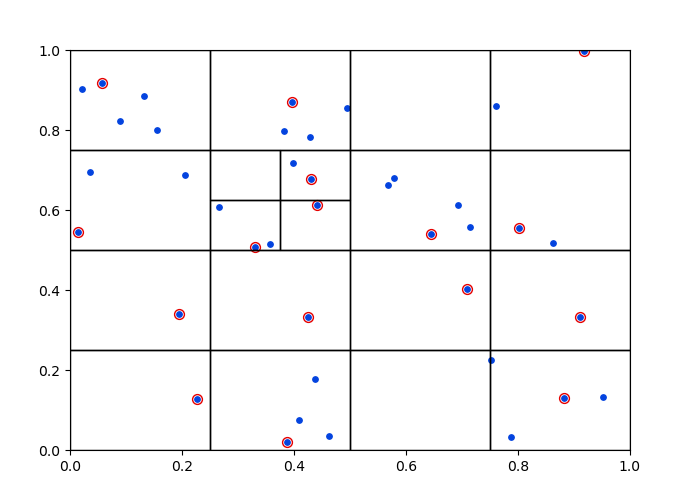

In [58]:
fig=plt.figure(figsize=(7,5))
fig.subplots_adjust(bottom=0.1, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.5)




sub = fig.add_subplot(111)

# cc=np.array(Qt.get_centers())
# sub.scatter(cc[:,0],cc[:,1],c='xkcd:black',s=15)
can=np.array(Qt.candidates()[1])
if len(can)!=0:
    sub.scatter(can[:,0],can[:,1],c='w',edgecolor='xkcd:red',s=50,marker='o')


pp=np.array(Qt.get_points())
if len(pp)!=0:
    sub.scatter(pp[:,0],pp[:,1],c='xkcd:blue',s=15,marker='o')


sq=np.array(Qt.get_last_nodes())
for _ in sq:
    sub.add_patch(
        Rectangle((_.boundary.center[0]-_.boundary.distance,_.boundary.center[1]-_.boundary.distance), 
                  _.boundary.distance*2, _.boundary.distance*2,
        facecolor='none',edgecolor='xkcd:black'),
    )




sub.set_xlim(0,1)
sub.set_ylim(0,1) 
plt.show()